# Flatiron Module 2 Project

Work of Mate Pocs, January 2020. 

## Introcution
Purpose of the project is to explore the Football Delphi database from kaggle (https://www.kaggle.com/laudanum/footballdelphi), run SQL queries on it, obtain weather information from Dark Sky API, and at the end of the project, create a MongoDB database in the following structure: 
- The name of the team
- The total number of goals scored by the team during the 2011 season
- The total number of wins the team earned during the 2011 season
- A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly by assigning it to a variable)
- The team's win percentage on days where it was raining during games in the 2011 season.
<br><br>
The project has the following structure: 
<br><br>
- __Section 1 - SQL Infrastructure__: Importing libraries and setting up a class that will handle the SQL queries.
- __Section 2 - Data Exploration__: Exploring the databases, by running SQL queries. By the end, we will have a Pandas DataFrame containing information of the relevant matches, and another DataFrame we will use to document the daily weather conditions. 
- __Section 3 - API Structure Exploration__: In this section, we are setting up the API key, and exploring the possibilities of the Dark Sky API. We look into the json data and try to come up with a good algorithm that signals if it was raining on a particular day. 
- __Section 4 - Saving Weather Information__: This is the section where we request weather information for the dates when matches were played in the 2011 season. First, we get the json data information, and save that for future reference. Then, we run a method that decides if it was raining on a particular day. We are saving the rainy day indicator file in a csv. 
- __Section 5 - Combining the Data__: We create a combined dataframe of the two main dataframes we got as a result of the previous sections. The combined database will contain the names of the different teams in one column, and the requested statistics in the other columns. 
- __Section 6 - MongoDB__: We create a new MongoDB database and enter the combined results. 

## Section 1 - SQL Infrasturcure
In this section, we are importing libraries and set up a class that will handle the SQL queries. 

In [10]:
#import relevant libraries, establish SQL connection
import sqlite3
import pandas as pd
football_conn = sqlite3.connect('database.sqlite')
football_cur = football_conn.cursor()

In [11]:
# create a class that will handle the SQL queries
# we are going to run one object of this class during the project
class QueryHandler():
    """
    Handles SQL queries of one established cursor. 
    """
    def __init__(self, cur = football_cur):
        """
        Initialize class, save cursor.
        """
        self.cur = cur
        
    def save_in_df(self, query):
        """
        Returns a Pandas DataFrame from the SQL query, using object's cursor 
        """
        self.cur.execute(query)
        df = pd.DataFrame(self.cur.fetchall())
        df.columns = [x[0] for x in self.cur.description]
        return df

In [12]:
# creating object that we are using in the following section to run our queries
football_query = QueryHandler(football_cur)

## Section 2 - Data Exploration
In this section, we are using the QueryHandler to get ourselves familiar with the data.

The database has the following databases: Matches, Teams, Unique Teams, Teams_in_Matches. Starting analysis with Matches. 

In [13]:
match_df = football_query.save_in_df("""SELECT * FROM Matches;""")

In [14]:
match_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [15]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24625 entries, 0 to 24624
Data columns (total 9 columns):
Match_ID    24625 non-null int64
Div         24625 non-null object
Season      24625 non-null int64
Date        24625 non-null object
HomeTeam    24625 non-null object
AwayTeam    24625 non-null object
FTHG        24625 non-null int64
FTAG        24625 non-null int64
FTR         24625 non-null object
dtypes: int64(4), object(5)
memory usage: 1.7+ MB


From database description on Kaggle: 
- Match ID: unique ID 
- Div: division (Bundesligas, English Premier League)
- Season: season of the match, we only need the 2011 matches
- Date: date of the match, we will definitely need thisfor the weather matching
- HomeTeam, AwayTeam: names of teams, we will need this column
- FTHG, FTAG: Full Time Home / Away Goals, coded as integers
- FTR: Full Time Result, code showing which team won, H: Home, A: Away, D: Draw
<br><br>

It looks like we won't need other tables from the database to answer the question. 

In [16]:
# filtering down to 2011 matches only. 
match_2011_df = football_query.save_in_df("""SELECT * FROM Matches WHERE Season = "2011";""")
match_2011_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [17]:
# summary statistics
print("Total Home Goals: " + str(match_2011_df['FTHG'].sum()))
print("Total Away Goals: " + str(match_2011_df['FTAG'].sum()))
print("Number of Home Teams: " + str(len(match_2011_df['HomeTeam'].unique())))
print("Number of Away Teams: " + str(len(match_2011_df['AwayTeam'].unique())))
print("Number of Home / Away Wins & Draws :")
print(match_2011_df['FTR'].value_counts())

Total Home Goals: 1600
Total Away Goals: 1196
Number of Home Teams: 56
Number of Away Teams: 56
Number of Home / Away Wins & Draws :
H    450
A    279
D    263
Name: FTR, dtype: int64


In [18]:
# home team goals
query = """
    SELECT HomeTeam, SUM(FTHG) as Total_Goals
    FROM Matches 
    WHERE Season = "2011"
    GROUP BY HomeTeam
    ;"""
df = football_query.save_in_df(query)
df.head()

,HomeTeam,Total_Goals
0,Aachen,15
1,Arsenal,39
2,Aston Villa,20
3,Augsburg,20
4,Bayern Munich,49


In [19]:
# home team wins
query = """
    SELECT HomeTeam, COUNT(HomeTeam) AS Total_Wins
    FROM Matches 
    WHERE Season = "2011" AND FTR = "H"
    GROUP BY HomeTeam
    ;"""
df = football_query.save_in_df(query)
df.head()

,HomeTeam,Total_Wins
0,Aachen,4
1,Arsenal,12
2,Aston Villa,4
3,Augsburg,6
4,Bayern Munich,14


The same could be repeated for the Away Team, but I am going to use the match_2011_df database going forward, without SQL queries. 

In [20]:
# one other item we need: create a list of dates we need the weather for
len(match_2011_df['Date'].unique())

165

In [21]:
# creating a separate database with the dates, weather summary, and the rain boolean
season_2011_daily_weather = pd.DataFrame(columns = ["date", "weather_summary", "rain_bool"])

In [22]:
season_2011_daily_weather['date'] = match_2011_df['Date'].unique()

__Summary__:

We created a database of the 2011 season, match_2011_df. It has most of the information we will need to answer the questions. 

Then, we created a smaller database with the unique date lists from the 2011 season, called season_2011_daily_weather. In order to not issue too many requests to the API, we are going to populate this database. (An alternative approach would be to request the weather individually for each match, but that would be less efficient, plus we would run out of the free 1,000 daily requests after only one loop, leaving no room for error.)

## Section 3 - API Structure Exploration
In this section, we are exploring the possibilities of the API we are going to use to get the weather. We are running testing requests and explore the structure of the resulting json file, trying to come up with a good indicator of whether it was raining on that day. 

Important note: I am using an API key that I store on my computer, in order to avoid hardcoding it. The variable api_key is used to contain this string, you will need a similar key in order to run the requests. 

In [26]:
#importing libraries necessary for defining the method to obtain API keys
import json
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [27]:
keys = get_keys("/Users/flatiron/.secret/darksky_api.json")

api_key = keys['api_key']

In [377]:
# importing further libraries, setting up default URL

In [28]:
import requests

In [29]:
url = "https://api.darksky.net/forecast/"

In [84]:
# testing response first

In [81]:
response = requests.get(url + api_key + "/42.3601,-71.0589,255657600")

In [83]:
print(response.text[:1000])

{"latitude":42.3601,"longitude":-71.0589,"timezone":"America/New_York","currently":{"time":255657600,"summary":"Snow and Dangerously Windy","icon":"snow","precipIntensity":0.1692,"precipProbability":1,"precipType":"snow","precipAccumulation":1.7634,"temperature":30.89,"apparentTemperature":14.34,"dewPoint":30.8,"humidity":1,"pressure":1005.7,"windSpeed":39.46,"windGust":96.13,"windBearing":64,"cloudCover":1,"uvIndex":0,"visibility":0.201},"hourly":{"summary":"Snow throughout the day.","icon":"snow","data":[{"time":255589200,"summary":"Overcast","icon":"cloudy","precipIntensity":0,"precipProbability":0,"temperature":23.94,"apparentTemperature":18.11,"dewPoint":16.98,"humidity":0.74,"pressure":1026.8,"windSpeed":4.55,"windBearing":350,"cloudCover":0.88,"uvIndex":0,"visibility":9.997},{"time":255592800,"summary":"Mostly Cloudy","icon":"partly-cloudy-night","precipIntensity":0,"precipProbability":0,"temperature":24.08,"apparentTemperature":14.45,"dewPoint":17.74,"humidity":0.76,"pressure":

In [86]:
response.json().keys()

dict_keys(['latitude', 'longitude', 'timezone', 'currently', 'hourly', 'daily', 'flags', 'offset'])

In [99]:
response.json()['daily']['data'][0]['summary']

'Snow and dangerously windy throughout the day.'

In [100]:
# this would be a good candidate for a rain indicator, if the string contains the word rain, it is raining.

In [7]:
# trying request with more readable time, to avoid using UNIX times, 
# plus we will need to pass on the string dates from the table 
response = requests.get(url + api_key + "/42.3601,-71.0589,2020-01-29T19:00:00")

In [8]:
response.json()

{'latitude': 42.3601,
 'longitude': -71.0589,
 'timezone': 'America/New_York',
 'currently': {'time': 1580342400,
  'summary': 'Clear',
  'icon': 'clear-night',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 33.89,
  'apparentTemperature': 26.67,
  'dewPoint': 11.06,
  'humidity': 0.38,
  'pressure': 1018.7,
  'windSpeed': 8.82,
  'windGust': 14.96,
  'windBearing': 337,
  'cloudCover': 0.05,
  'uvIndex': 0,
  'visibility': 10,
  'ozone': 349.7},
 'hourly': {'summary': 'Clear throughout the day.',
  'icon': 'clear-day',
  'data': [{'time': 1580274000,
    'summary': 'Partly Cloudy',
    'icon': 'partly-cloudy-night',
    'precipIntensity': 0.0011,
    'precipProbability': 0.02,
    'precipType': 'snow',
    'precipAccumulation': 0.0089,
    'temperature': 33.86,
    'apparentTemperature': 26.7,
    'dewPoint': 22.35,
    'humidity': 0.62,
    'pressure': 1011.8,
    'windSpeed': 8.72,
    'windGust': 18.55,
    'windBearing': 328,
    'cloudCover': 0.48,
    'uvInde

In [9]:
response.json()['daily']['data'][0]['summary']

'Clear throughout the day.'

In [10]:
#seems to work properly

In [29]:
# one more test before setting up the structure, does it work with dates from the dataframe

In [31]:
response = requests.get(url + api_key + "/42.3601,-71.0589," + season_2011_daily_weather['date'][0] +"T19:00:00")

In [32]:
response.json()['daily']['data'][0]['summary']

'Possible drizzle in the morning.'

__Summary__: In this section, we explored the results we get from the API. Seems to be working properly with the date and time functions we want to pass on. We identified some possible indicators of whether it was raining that day. As we progress further in the next section, we will have to build a more complicated function, the json data will not be identical for all dates. 

## Section 4 - Saving Weather Information

In this section, we populate the season_2011_daily_weather DataFrame that we created in Section 2. The main focus of this section is the class called WeatherGetter, which handles the API requests and the json analysis. 

In [23]:
# in order to avoid exceeding the daily request limit, we are testing our work on a small database first
test_data = season_2011_daily_weather[:4].copy()

In [24]:
# Please note that the get_summary method ended up not being used, 
# it was difficult to test a system that could decide the rain_bool at runtime. 
# So we used the get_json method instead, saved the results, and continued experimenting 
# without the need to run more requests. 

class WeatherGetter():
    """
    Class that 
    - handles requests to Dark Sky API
    - contains an other weather-related function
    """
    def __init__(
        self, url = "https://api.darksky.net/forecast/", 
        lat = 52.520008, long = 13.404954, time = "T19:00:00"
    ):
        """
        Get API key, get request values.
        Defaults to darksky url, Berlin lat - long. 
        Important assumption: we need to enter an exact time, used 19:00 as a default.
        """
        #In this project, we are always using the default values. 
        
        # get API key
        keys = get_keys("/Users/flatiron/.secret/darksky_api.json")
        self.api_key = keys['api_key']
        
        # intialize URL, lattitue, longitude, if these were not defined, we are reverting back to the default
        self.url = url
        self.lat = lat
        self.long = long
        self.time = time
    
    def get_response(self, date):
        """
        Runs the request with the API.
        """
        response = requests.get(
            self.url + self.api_key + "/" + str(self.lat) + "," + str(self.long) + "," + date + self.time
        )
        return response
    
    def get_json(self, date):
        """
        Returns full json data.
        """
        response = self.get_response(date)
        json_data = response.json()
        return json_data
    
    def get_summary(self, date):
        """
        Returns weather summary string of particular date. 
        """
        response = self.get_response(date)
        summary = response.json()['hourly']['summary']
        return summary
    
    @staticmethod
    def is_raining(json_data):
        """
        Decides if rain_bool should be set to true or false, based on the json data.
        """
        # This function is the result of an iterative process, I first set them all to Not Decided.
        # Then added the possible ways I found to be a logical indication of whether it was raining or not.
        # Repeated the process until we had no Not Decideds in the data.
        # In the end, I realized that the best indicator was possibly the icon, so I moved that up in the order.
        
        rain = "Not Decided"

        if 'hourly' in json_data.keys() and rain == "Not Decided":
            if 'icon' in json_data['hourly'].keys():
                rain = (json_data['hourly']['icon'] == 'rain')
        
        if 'currently' in json_data.keys() and rain == "Not Decided":
            if 'summary' in json_data['currently'].keys():
                rain = ('rain' in json_data['currently']['summary'].lower())
                
        if 'hourly' in json_data.keys() and rain == "Not Decided":
            if 'summary' in json_data['hourly'].keys():
                rain = ('rain' in json_data['hourly']['summary'].lower())
                
        if 'currently' in json_data.keys() and rain == "Not Decided":
            if 'precipIntensity' in json_data['currently'].keys():
                rain = json_data['currently']['precipIntensity'] > 0

        return rain
    

In [30]:
# #creating an object that we are going to use to handle requests
weather = WeatherGetter()

In the following part, I am running tests on the WeatherGetter class. I think it is worth leaving this information here, could be used in the future. The project continues after the next markdown cell. 

In [72]:
test = weather.get_response("2020-01-20")

In [73]:
test.json()

{'latitude': 52.520008,
 'longitude': 13.404954,
 'timezone': 'Europe/Berlin',
 'currently': {'time': 1579543200,
  'summary': 'Partly Cloudy',
  'icon': 'partly-cloudy-night',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 34.4,
  'apparentTemperature': 29.09,
  'dewPoint': 31.21,
  'humidity': 0.88,
  'pressure': 1045.7,
  'windSpeed': 6,
  'windGust': 16.22,
  'windBearing': 228,
  'cloudCover': 0.46,
  'uvIndex': 0,
  'visibility': 10,
  'ozone': 347.9},
 'hourly': {'summary': 'Partly cloudy throughout the day.',
  'icon': 'partly-cloudy-day',
  'data': [{'time': 1579474800,
    'summary': 'Overcast',
    'icon': 'cloudy',
    'precipIntensity': 0,
    'precipProbability': 0,
    'temperature': 38.33,
    'apparentTemperature': 38.33,
    'dewPoint': 33.67,
    'humidity': 0.83,
    'pressure': 1042.2,
    'windSpeed': 2.69,
    'windGust': 4.76,
    'windBearing': 258,
    'cloudCover': 0.9,
    'uvIndex': 0,
    'visibility': 10,
    'ozone': 373},
   {'time':

In [96]:
test.json()['currently']['summary']

'Partly Cloudy'

In [99]:
testsummary = weather.get_summary("2020-01-20")

In [100]:
testsummary

'Partly Cloudy'

In [106]:
WeatherGetter.was_raining(testsummary)

False

In [107]:
tests2 = "was raining like crazy"

In [108]:
WeatherGetter.was_raining(tests2)

True

In [124]:
testsummary = weather.get_summary(test_data['date'][0])

In [128]:
testsummary

'Partly Cloudy'

In [150]:
test_data['weather_summary'] = test_data['date'].map(lambda x: weather.get_summary(x))

In [151]:
test_data.head()

,date,weather_summary,rain_bool
0,2012-03-31,Drizzle in the morning and afternoon.,NaN
1,2011-12-11,Mostly cloudy throughout the day.,NaN
2,2011-08-13,Partly cloudy throughout the day.,NaN
3,2011-11-27,Windy in the evening.,NaN


In [147]:
test_data['weather_summary'][1]['hourly']['summary']

'Mostly cloudy throughout the day.'

In [152]:
# saving this in a csv
test_data.to_csv('weather_summary_test')

In [153]:
test_data['rain_bool'] = test_data['weather_summary'].map(lambda x: WeatherGetter.was_raining(x))

In [154]:
test_data.head()

,date,weather_summary,rain_bool
0,2012-03-31,Drizzle in the morning and afternoon.,False
1,2011-12-11,Mostly cloudy throughout the day.,False
2,2011-08-13,Partly cloudy throughout the day.,False
3,2011-11-27,Windy in the evening.,False


In [155]:
# saving this in a csv
test_data.to_csv('weather_summary_test')

After the testing above, we continue with the project. 

I realized that coming up with a good way to decide if it was raining for the full list of 165 dates would be more convenient with the json data at hand. The next cell is commented out to avoid accidentally running it. It will run the API request 165 times to import the json data in our dataframe. 

In [170]:
# uncomment to run

# season_2011_daily_weather['weather_summary'] = \
# season_2011_daily_weather['date'].map(lambda x: weather.get_json(x))

I immediately saved the results in a csv, this is also commented out. 

In [378]:
# saving database

# season_2011_daily_weather.to_csv('weather_summary_test')

In the next cell, we are applying the is_raining method from the WeatherGetter class. 

In [247]:
season_2011_daily_weather['rain_bool'] = \
season_2011_daily_weather['weather_summary'].map(lambda x: WeatherGetter.is_raining(x))

In [379]:
season_2011_daily_weather[season_2011_daily_weather['rain_bool'] == True].head()

,date,weather_summary,rain_bool
0,2012-03-31,"{'latitude': 52.520008, 'longitude': 13.404954...",True
5,2012-01-20,"{'latitude': 52.520008, 'longitude': 13.404954...",True
8,2011-09-18,"{'latitude': 52.520008, 'longitude': 13.404954...",True
15,2012-05-05,"{'latitude': 52.520008, 'longitude': 13.404954...",True
17,2011-12-17,"{'latitude': 52.520008, 'longitude': 13.404954...",True


In [254]:
len(season_2011_daily_weather[season_2011_daily_weather['rain_bool'] == True])

43

In [ ]:
# 43 rainy day out of 165, does not seem unreasonable

In [249]:
# spot checking a couple json that is set to true

In [252]:
season_2011_daily_weather['weather_summary'][158]

{'latitude': 52.520008,
 'longitude': 13.404954,
 'timezone': 'Europe/Berlin',
 'currently': {'time': 1335286800,
  'summary': 'Overcast',
  'icon': 'cloudy',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 53.6,
  'apparentTemperature': 53.6,
  'dewPoint': 44,
  'humidity': 0.7,
  'windSpeed': 14.96,
  'windGust': 14.96,
  'windBearing': 270,
  'cloudCover': 0.95,
  'uvIndex': 0,
  'visibility': 5.808},
 'hourly': {'summary': 'Light rain overnight and in the evening.',
  'icon': 'rain',
  'data': [{'time': 1335218400,
    'precipIntensity': 0,
    'precipProbability': 0,
    'temperature': 47.03,
    'apparentTemperature': 43.66,
    'dewPoint': 35.77,
    'humidity': 0.65,
    'windSpeed': 6.91,
    'windGust': 8.99,
    'windBearing': 128,
    'uvIndex': 0,
    'visibility': 6.206},
   {'time': 1335222000,
    'precipIntensity': 0,
    'precipProbability': 0,
    'temperature': 47.03,
    'apparentTemperature': 43.66,
    'dewPoint': 34.57,
    'humidity': 0.62,
 

In [253]:
season_2011_daily_weather['weather_summary'][126]

{'latitude': 52.520008,
 'longitude': 13.404954,
 'timezone': 'Europe/Berlin',
 'currently': {'time': 1330365600,
  'summary': 'Mostly Cloudy',
  'icon': 'partly-cloudy-night',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 37.4,
  'apparentTemperature': 30.9,
  'dewPoint': 33.41,
  'humidity': 0.85,
  'windSpeed': 8.99,
  'windGust': 8.99,
  'windBearing': 228,
  'cloudCover': 0.8,
  'uvIndex': 0,
  'visibility': 4.483},
 'hourly': {'summary': 'Drizzle overnight and in the evening.',
  'icon': 'rain',
  'data': [{'time': 1330297200,
    'precipIntensity': 0,
    'precipProbability': 0,
    'temperature': 29.31,
    'apparentTemperature': 25.64,
    'dewPoint': 18,
    'humidity': 0.62,
    'windSpeed': 3.46,
    'windGust': 3.46,
    'windBearing': 270,
    'uvIndex': 0,
    'visibility': 6.206},
   {'time': 1330300800,
    'precipIntensity': 0,
    'precipProbability': 0,
    'temperature': 27.38,
    'apparentTemperature': 22.74,
    'dewPoint': 19.13,
    'humid

In [257]:
# finally, saving the rain bool database in a csv so we do not have to run the API again
rainy_days_2011_df = season_2011_daily_weather[['date', 'rain_bool']].copy()

In [258]:
rainy_days_2011_df.to_csv('season2011_rainydays')

__Summary__: At the ed of this section, we have a dataframe (and a saved .csv) where one column is the list of days in the 2011 season where matches were played, and the other column is a boolean signifying if it was raining on that particular day. True = it was raining, False = it was not. 
<br><br>
We used the 19:00 local time Berlin as a proxy to see if it was raining, as per the instructions of the project. 

## Section 5 - Combining the Data
In this section, we take the two databases, rainy_days_2011_df, and match_2011_df, combine them in one database to answer the questions. 
<br><br>
If you are not running the API sections, the rainy days can be imported from a .csv file, this is done in the next cell. 

In [32]:
# uncomment to import the rainy_days_2011_df from a .csv
# as a default, this df is created in the previous section

rainy_days_2011_df = pd.read_csv('season2011_rainydays')

In [33]:
# creating a list of rainy days
list_of_rainy_dates = rainy_days_2011_df[rainy_days_2011_df['rain_bool'] == True]['date']
len(list_of_rainy_dates)

43

In [34]:
# not rainy days
list_of_notrainy_dates = rainy_days_2011_df[rainy_days_2011_df['rain_bool'] == False]['date']
len(list_of_notrainy_dates)

122

In [35]:
# creating an empty dataframe to be populated
combined_df = pd.DataFrame(columns = [
    'team_name', 'goals', 'wins', 'losses', 'rainy_wins', 'rainy_losses', 'notrainy_wins', 'notrainy_losses'
])

In [36]:
# creating a list of teams, unique, containing each team once
list_of_teams = pd.unique(match_2011_df[['HomeTeam', 'AwayTeam']].values.ravel('K'))

In [37]:
list_of_teams.sort()
list_of_teams

array(['Aachen', 'Arsenal', 'Aston Villa', 'Augsburg', 'Bayern Munich',
       'Blackburn', 'Bochum', 'Bolton', 'Braunschweig', 'Chelsea',
       'Cottbus', 'Dortmund', 'Dresden', 'Duisburg', 'Ein Frankfurt',
       'Erzgebirge Aue', 'Everton', 'FC Koln', 'Fortuna Dusseldorf',
       'Frankfurt FSV', 'Freiburg', 'Fulham', 'Greuther Furth', 'Hamburg',
       'Hannover', 'Hansa Rostock', 'Hertha', 'Hoffenheim', 'Ingolstadt',
       'Kaiserslautern', 'Karlsruhe', 'Leverkusen', 'Liverpool',
       "M'gladbach", 'Mainz', 'Man City', 'Man United', 'Munich 1860',
       'Newcastle', 'Norwich', 'Nurnberg', 'Paderborn', 'QPR',
       'Schalke 04', 'St Pauli', 'Stoke', 'Stuttgart', 'Sunderland',
       'Swansea', 'Tottenham', 'Union Berlin', 'Werder Bremen',
       'West Brom', 'Wigan', 'Wolfsburg', 'Wolves'], dtype=object)

In [38]:
# populating the first column with 
combined_df['team_name'] = list_of_teams

In the following section, we are defining a number of functions we will use to populate our combined dataframe. 
<br><br>
Please note that this is not an efficient solution, we are looping through the same tables many times in order to populate the combined table. However, the size of the tables is small, and I find this to be a very transparent approach. 

In [39]:
def get_total_wins(team_name):
    """
    Loops through match_2011_df, if home or away team is equal to team_name, adds total wins. 
    """
    total_wins = 0
    # first, total home wins
    total_wins += len(match_2011_df[(match_2011_df['HomeTeam'] == team_name) & (match_2011_df['FTR'] == "H")])
    
    # second, total away wins
    total_wins += len(match_2011_df[(match_2011_df['AwayTeam'] == team_name) & (match_2011_df['FTR'] == "A")])
    return total_wins

In [40]:
def get_total_losses(team_name):
    """
    Loops through match_2011_df, if home or away team is equal to team_name, adds total losses. 
    """
    total_losses = 0
    # first, total home wins
    total_losses += len(match_2011_df[(match_2011_df['HomeTeam'] == team_name) & (match_2011_df['FTR'] == "A")])
    
    # second, total away wins
    total_losses += len(match_2011_df[(match_2011_df['AwayTeam'] == team_name) & (match_2011_df['FTR'] == "H")])
    return total_losses

In [41]:
def get_total_goals(team_name):
    """
    Loops through match_2011_df, if home or away team is equal to team_name, adds total goals. 
    """
    total_goals = 0
    # first, total home wins
    total_goals += match_2011_df[match_2011_df['HomeTeam'] == team_name]['FTHG'].sum()
    
    # second, total away wins
    total_goals += match_2011_df[match_2011_df['AwayTeam'] == team_name]['FTAG'].sum()
    return total_goals

In [42]:
def get_total_rainy_wins(team_name):
    """
    Loops through match_2011_df, if home or away team is equal to team_name, adds total wins. 
    """
    total_rainy_wins = 0
    # first, total home wins
    total_rainy_wins += len(match_2011_df[
        (match_2011_df['HomeTeam'] == team_name) & 
        (match_2011_df['FTR'] == "H") & 
        (match_2011_df['Date'].isin(list_of_rainy_dates))
    ])
    
    # second, total away wins
    total_rainy_wins += len(match_2011_df[
        (match_2011_df['AwayTeam'] == team_name) & 
        (match_2011_df['FTR'] == "A") & 
        (match_2011_df['Date'].isin(list_of_rainy_dates))
    ])
    
    return total_rainy_wins

In [43]:
def get_total_rainy_losses(team_name):
    """
    Loops through match_2011_df, if home or away team is equal to team_name, adds total wins. 
    """
    total_rainy_losses = 0
    # first, total home wins
    total_rainy_losses += len(match_2011_df[
        (match_2011_df['HomeTeam'] == team_name) & 
        (match_2011_df['FTR'] == "A") & 
        (match_2011_df['Date'].isin(list_of_rainy_dates))
    ])
    
    # second, total away wins
    total_rainy_losses += len(match_2011_df[
        (match_2011_df['AwayTeam'] == team_name) & 
        (match_2011_df['FTR'] == "H") & 
        (match_2011_df['Date'].isin(list_of_rainy_dates))
    ])
    
    return total_rainy_losses

In [44]:
# not in the project task, but for checking purposes, I'm also calculating the not rainy wins and losses

In [45]:
def get_total_notrainy_wins(team_name):
    """
    Loops through match_2011_df, if home or away team is equal to team_name, adds total wins. 
    """
    total_notrainy_wins = 0
    # first, total home wins
    total_notrainy_wins += len(match_2011_df[
        (match_2011_df['HomeTeam'] == team_name) & 
        (match_2011_df['FTR'] == "H") & 
        (match_2011_df['Date'].isin(list_of_notrainy_dates))
    ])
    
    # second, total away wins
    total_notrainy_wins += len(match_2011_df[
        (match_2011_df['AwayTeam'] == team_name) & 
        (match_2011_df['FTR'] == "A") & 
        (match_2011_df['Date'].isin(list_of_notrainy_dates))
    ])
    
    return total_notrainy_wins

In [46]:
def get_total_notrainy_losses(team_name):
    """
    Loops through match_2011_df, if home or away team is equal to team_name, adds total wins. 
    """
    total_notrainy_losses = 0
    # first, total home wins
    total_notrainy_losses += len(match_2011_df[
        (match_2011_df['HomeTeam'] == team_name) & 
        (match_2011_df['FTR'] == "A") & 
        (match_2011_df['Date'].isin(list_of_notrainy_dates))
    ])
    
    # second, total away wins
    total_notrainy_losses += len(match_2011_df[
        (match_2011_df['AwayTeam'] == team_name) & 
        (match_2011_df['FTR'] == "H") & 
        (match_2011_df['Date'].isin(list_of_notrainy_dates))
    ])
    
    return total_notrainy_losses

In [47]:
# next, we are applying the functions on the team name column of the databse

In [48]:
combined_df['goals'] = combined_df['team_name'].map(lambda x: get_total_goals(x))

In [49]:
combined_df['wins'] = combined_df['team_name'].map(lambda x: get_total_wins(x))

In [50]:
combined_df['losses'] = combined_df['team_name'].map(lambda x: get_total_losses(x))

In [51]:
combined_df['rainy_wins'] = combined_df['team_name'].map(lambda x: get_total_rainy_wins(x))

In [52]:
combined_df['rainy_losses'] = combined_df['team_name'].map(lambda x: get_total_rainy_losses(x))

In [53]:
combined_df['notrainy_wins'] = combined_df['team_name'].map(lambda x: get_total_notrainy_wins(x))

In [54]:
combined_df['notrainy_losses'] = combined_df['team_name'].map(lambda x: get_total_notrainy_losses(x))

In [55]:
combined_df.head()

,team_name,goals,wins,losses,rainy_wins,rainy_losses,notrainy_wins,notrainy_losses
0,Aachen,30,6,15,2,1,4,14
1,Arsenal,74,21,10,3,4,18,6
2,Aston Villa,37,7,14,0,6,7,8
3,Augsburg,36,8,12,3,0,5,12
4,Bayern Munich,77,23,7,5,2,18,5


In [361]:
# running a check on total wins and losses

In [56]:
combined_df['check_wins'] = (combined_df['wins'] == combined_df['rainy_wins'] + combined_df['notrainy_wins'])

In [57]:
combined_df[combined_df['check_wins'] == False]

,team_name,goals,wins,losses,rainy_wins,rainy_losses,notrainy_wins,notrainy_losses,check_wins


In [58]:
combined_df['check_losses'] = (combined_df['losses'] == combined_df['rainy_losses'] + combined_df['notrainy_losses'])

In [59]:
combined_df[combined_df['check_losses'] == False]

,team_name,goals,wins,losses,rainy_wins,rainy_losses,notrainy_wins,notrainy_losses,check_wins,check_losses


In [381]:
# the rainy - not rainy split seems to be correct
# one final thing to check: are the column totals matchinhg the numbers we initially calculated, in Section 1? 

In [60]:
combined_df.goals.sum()

2796

In [61]:
combined_df.wins.sum()

729

In [62]:
combined_df.losses.sum()

729

In [382]:
# everything seems to be in order

In [81]:
# as a last step to the dataframe, create rainy_day_winratio
combined_df['rainy_day_winratio'] = \
combined_df['rainy_wins'] / (combined_df['rainy_wins'] + combined_df['rainy_losses'])

In [82]:
# in the following, we are saving individual histograms on our computer as pictures

In [92]:
import matplotlib.pyplot as plt

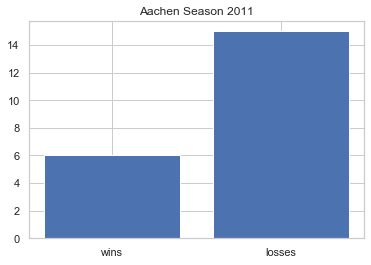

In [123]:
plt.bar(x = ['wins', 'losses'], height = [combined_df.iloc[0]['wins'], combined_df.iloc[0]['losses']])
plt.title(combined_df.iloc[0]['team_name'] + " Season 2011")
plt.savefig('charts/winloss_hist_0.png')

In [185]:
for i in range(0, len(combined_df)):
    plt.bar(x = ['wins', 'losses'], height = [combined_df.iloc[i]['wins'], combined_df.iloc[i]['losses']])
    plt.title(combined_df.iloc[i]['team_name'] + " Season 2011")
    plt.savefig('charts/winloss_hist_' + str(i) + '.png')
    plt.show()
    ;

__Summary__: In this section, we combined the work we have done so far, in combined_df, which should contain all the information we need to upload to a MongoDB database as the final step of the project. We also calculated and saved the histograms for each team separately. 

## Setion 6 - MongoDB
In this section, we create a new MongoDB database, and enter the results we calculated. 
<br><br>
Please note that the database I used was hosted on my own computer. 

In [124]:
# import relevant libraries
import pymongo

In [125]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")

# grab a database from your server 
mydb = myclient['flatiron_project2_data']

In [133]:
# initialise an empty collection
mycollection = mydb['teams_season2011_summary']

In [66]:
# next, we are going to cycle through the combined df,
# and save the relevant statistics in a separete document, 
# by team
# using pandas iterrows

In [127]:
# testing iterrows
for index, row in combined_df.head(1).iterrows():
    print(row)
    print(row['team_name'])

team_name               Aachen
goals                       30
wins                         6
losses                      15
rainy_wins                   2
rainy_losses                 1
notrainy_wins                4
notrainy_losses             14
check_wins                True
check_losses              True
rainy_day_winratio    0.666667
Name: 0, dtype: object
Aachen


In [179]:
# cant figure out how to convert images to bytes, this code is from stack overflow

from PIL import Image
import io

def image_to_byte_array(image:Image):
  imgByteArr = io.BytesIO()
  image.save(imgByteArr, format=image.format)
  imgByteArr = imgByteArr.getvalue()
  return imgByteArr

In [182]:
mycollection.delete_many({})

In [184]:
for index, row in combined_df.iterrows():

    img = Image.open('charts/winloss_hist_'+ str(index) +'.png')
    b = image_to_byte_array(img)
    
    mongoDB_data = {
        'name' : row['team_name'], 'goals': row['goals'], 
        'wins': row['wins'], 'rainy_day_winratio' :  row['rainy_day_winratio'],
        'hist_img': b
    }
    mycollection.insert_one(mongoDB_data)

## Summary

In this project, we used SQL queries to import sections of a sqlite database, which included the details of years of football matches in Germany. We narrowed our focus to the 2011 season, and using a weather API, we gathered accurate weather information for the individual dates. This allowed us to create advanced analysis like the winrates of individual teams on rainy days. 
<br><br>
We combined our findings and saved the results (total goals, wins, winratios on rainy days, histogram of wins) for each individual team in a MongoDB document. 